In [1]:
# lpr_scregseg environment

In [2]:
import os
import pandas as pd
from anndata import read_h5ad
import scanpy as sc
import scregseg
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import binarize

## Swanson2021 - PBMC Multiome data whole (permeabilized) cells (perm_cells)

In [3]:
wd = "liam_manuscript_reproducibility/data/original/Swanson2021/perm_cells/"

In [4]:
tea_seq_metadata = pd.read_csv(wd + 'GSM5123950_X066-MP0C1W2_leukopak_perm-cells_multiome_200M_atac_filtered_metadata.csv.gz')

In [5]:
# Load GEX data

In [6]:
adata = sc.read_10x_h5(wd + "GSM5123950_X066-MP0C1W2_leukopak_perm-cells_multiome_200M_cellranger-arc_filtered_feature_bc_matrix.h5")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [7]:
adata

AnnData object with n_obs × n_vars = 8865 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

From Swanson et al., 2021 publication: "permeabilized cells on 10x Multiome: >300 genes, <2,750,750 genes, 8334 barcodes retained"

In [8]:
adata[(adata.X > 1).astype(int).sum(axis=1) > 300]
# this can't be it, way to few cells retained!

View of AnnData object with n_obs × n_vars = 3024 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [9]:
adata = adata[(adata.X.sum(axis=1) > 300) & (adata.X.sum(axis=1) < 2750750)]

In [10]:
adata

View of AnnData object with n_obs × n_vars = 8633 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

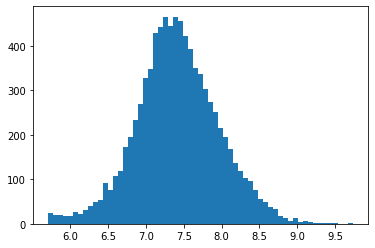

In [11]:
plt.hist(np.log(adata.X.sum(axis=1).flatten().tolist()[0]), bins="auto")
plt.show()

We chose a threshold of 500 to better match our other data sets data distributions.

In [12]:
adata = adata[(adata.X.sum(axis=1) > 500) & (adata.X.sum(axis=1) < 2750750)]

In [13]:
adata

View of AnnData object with n_obs × n_vars = 8461 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

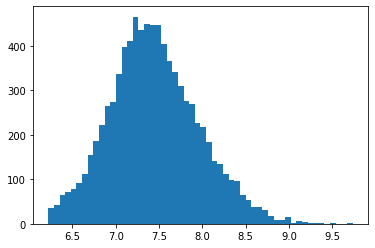

In [14]:
plt.hist(np.log(adata.X.sum(axis=1).flatten().tolist()[0]), bins="auto")
plt.show()

In [15]:
adata.obs["original_barcodes"] = adata.obs.index

Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [16]:
adata.obs = adata.obs.merge(tea_seq_metadata, left_on="original_barcodes", right_on="original_barcodes", how="left").set_index(adata.obs.index)

In [17]:
adata = adata[(~adata.obs["barcodes"].isna()),].copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [18]:
adata.obs.set_index("barcodes", inplace=True)

In [19]:
# Load ATAC data

Previously we created same bins as input for ATAC model as for the treatment-control use case.

The atac data is already subsetted to those cells that are called cells by the cell ranger pipeline.

In [20]:
adata_DNA = sc.read_h5ad("liam_manuscript_reproducibility/data/derived/Swanson2021/perm_cells/filtered_countmatrix_perm_cells_informative_rarest_states_out_of_50_0.h5ad").T

In [21]:
adata_DNA.obs = adata_DNA.obs.merge(tea_seq_metadata, left_index=True, right_on="barcodes", how="left").set_index(adata_DNA.obs.index)

Make DNA observations have same order as RNA observations! And subset to the same set of cells (reciprocally).

In [22]:
adata_DNA = adata_DNA[adata.obs.index[adata.obs.index.isin(adata_DNA.obs.index)],].copy()

In [23]:
adata = adata[adata.obs.index[adata.obs.index.isin(adata_DNA.obs.index)],].copy() 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [24]:
np.all(adata_DNA.obs.index == adata.obs.index)

True

In [25]:
# Binarize ATAC data

In [26]:
adata_DNA.X = binarize(adata_DNA.X, threshold=0.5)

In [27]:
adata.obsm["ATAC"] = adata_DNA.X.copy()

In [28]:
adata

AnnData object with n_obs × n_vars = 7051 × 36601
    obs: 'original_barcodes', 'n_fragments', 'n_duplicate', 'n_mito', 'n_unique', 'altius_count', 'altius_frac', 'gene_bodies_count', 'gene_bodies_frac', 'peaks_count', 'peaks_frac', 'tss_count', 'tss_frac', 'cell_name', 'well_id', 'chip_id', 'batch_id', 'pbmc_sample_id', 'DoubletScore', 'DoubletEnrichment', 'TSSEnrichment'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'ATAC'

In [29]:
adata.obs['batch'] = 'perm_cells'

In [30]:
adata.write("liam_manuscript_reproducibility/data/derived/Swanson2021/perm_cells/preprocessed_perm_cells.h5ad")

... storing 'well_id' as categorical
... storing 'chip_id' as categorical
... storing 'batch_id' as categorical
... storing 'pbmc_sample_id' as categorical
... storing 'batch' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
